!!!!!!!!!!!!! [9.9330717e-01 9.9987662e-01 1.7986210e-02 8.8079703e-01 9.9330717e-01
 9.9908900e-01 2.6894143e-01 7.3105860e-01 8.8079703e-01 9.9752742e-01
 6.6928510e-03 9.9752742e-01 2.6894143e-01 9.9330717e-01 9.9966466e-01
 9.9752742e-01 8.8079703e-01 6.6928510e-03 3.3535014e-04 1.7986210e-02
 9.1105117e-04 4.7425874e-02 7.3105860e-01 4.5397872e-05 2.6894143e-01
 7.3105860e-01 9.9752742e-01 9.1105117e-04 3.3535014e-04 9.9987662e-01
 8.8079703e-01 1.2339458e-04 7.3105860e-01 9.9987662e-01 7.3105860e-01
 9.9908900e-01 9.8201376e-01 9.9987662e-01 4.7425874e-02 5.0000000e-01
 7.3105860e-01 9.8201376e-01 9.9908900e-01 9.5257413e-01 4.5397872e-05
 8.8079703e-01 6.6928510e-03 9.9908900e-01 6.6928510e-03 9.5257413e-01
 9.9752742e-01 2.6894143e-01 1.1920292e-01 8.8079703e-01 1.7986210e-02
 8.8079703e-01 9.9987662e-01 9.9330717e-01 9.9908900e-01 9.9966466e-01
 9.8201376e-01 3.3535014e-04 6.6928510e-03 9.5257413e-01 1.7986210e-02
 4.7425874e-02 2.4726230e-03 9.1105117e-04 6.6928510e-03 9.8201

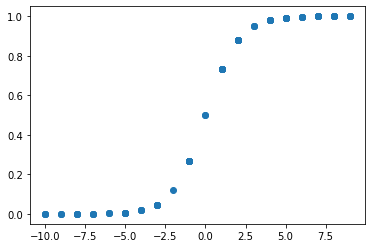

In [4]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

np.random.seed(1234)
tf.set_random_seed(1234)
x=np.random.randint(-10,10,size=100)
y=tf.sigmoid(tf.cast(x,tf.float32))
with tf.Session() as sess:
    y=y.eval()
#print("!!!!!!!!!!!!!",y)
plt.plot(x,y,'o')

In [ ]:

class ODE:
    def __init__(self,x,u,layers):
        self.lb=x.min(0)
        self.ub=x.max(0)
        self.x=x
        self.u=u
        self.layers=layers
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.x_tf=tf.placeholder(tf.float32,shape=[None,self.x.shape[1]]) 
        self.u_tf=tf.placeholder(tf.float32,shape=[None,self.u.shape[1]])  
        self.u_pred,self.f_u_pred=self.net_NS(self.x_tf)   
        self.loss=tf.reduce_sum(tf.square(self.u_tf-self.u_pred)+tf.reduce_sum(tf.square(self.f_u_pred)))   
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
    '''    
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
        
        return u, v, p, f_u, f_v
    '''
    def net_NS(self,x):
        lambda_1=self.lambda_1
        lambda_2=self.lambda_2
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))


In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, u, v, layers):
        
        X = np.concatenate([x, y, t], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        
        self.u = u
        self.v = v
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_sum(tf.square(self.f_u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_v_pred))
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
        
        return u, v, p, f_u, f_v
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

def plot_solution(X_star, u_star, index):
    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
        

In [ ]:
        
if __name__ == "__main__": 
      
    N_train = 5000
    
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
    
    # Load Data
    data = scipy.io.loadmat('../Data/cylinder_nektar_wake.mat')
           
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1
    
    u = UU.flatten()[:,None] # NT x 1
    v = VV.flatten()[:,None] # NT x 1
    p = PP.flatten()[:,None] # NT x 1
    
    ######################################################################
    ######################## Noiseles Data ###############################
    ######################################################################
    # Training Data    
    idx = np.random.choice(N*T, N_train, replace=False)
    x_train = x[idx,:]
    y_train = y[idx,:]
    t_train = t[idx,:]
    u_train = u[idx,:]
    v_train = v[idx,:]

    # Training
    model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
    model.train(200000)
    
    # Test Data
    snap = np.array([100])
    x_star = X_star[:,0:1]
    y_star = X_star[:,1:2]
    t_star = TT[:,snap]
    
    u_star = U_star[:,0,snap]
    v_star = U_star[:,1,snap]
    p_star = P_star[:,snap]
    
    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
    lambda_1_value = model.sess.run(model.lambda_1)
    lambda_2_value = model.sess.run(model.lambda_2)
    
    # Error
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

    error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
    error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100
    
    print('Error u: %e' % (error_u))    
    print('Error v: %e' % (error_v))    
    print('Error p: %e' % (error_p))    
    print('Error l1: %.5f%%' % (error_lambda_1))                             
    print('Error l2: %.5f%%' % (error_lambda_2))                  
    
    # Plot Results
#    plot_solution(X_star, u_pred, 1)
#    plot_solution(X_star, v_pred, 2)
#    plot_solution(X_star, p_pred, 3)    
#    plot_solution(X_star, p_star, 4)
#    plot_solution(X_star, p_star - p_pred, 5)
    
    # Predict for plotting
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
    
    
    ######################################################################
    ########################### Noisy Data ###############################
    ######################################################################
    noise = 0.01        
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])    

    # Training
    model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
    model.train(200000)
        
    lambda_1_value_noisy = model.sess.run(model.lambda_1)
    lambda_2_value_noisy = model.sess.run(model.lambda_2)
      
    error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
    error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01)/0.01 * 100
        
    print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
    print('Error l2: %.5f%%' % (error_lambda_2_noisy))     

             
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
     # Load Data
    '''
    data_vort = scipy.io.loadmat('../Data/cylinder_nektar_t0_vorticity.mat')
           
    x_vort = data_vort['x'] 
    y_vort = data_vort['y'] 
    w_vort = data_vort['w'] 
    modes = np.asscalar(data_vort['modes'])
    nel = np.asscalar(data_vort['nel'])    
    
    xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
    yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
    ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')
    
    box_lb = np.array([1.0, -2.0])
    box_ub = np.array([8.0, 2.0])
    
    fig, ax = newfig(1.0, 1.2)
    ax.axis('off')
    
    ####### Row 0: Vorticity ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    for i in range(0, nel):
        h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3) 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
    ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Vorticity', fontsize = 10)
    
    
    ####### Row 1: Training data ##################
    ########      u(t,x,y)     ###################        
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
    ax = plt.subplot(gs1[:, 0],  projection='3d')
    ax.axis('off')

    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]       
    r3 = [y_star.min(), y_star.max()]
    
    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    axisEqual3D(ax)
    
    ########      v(t,x,y)     ###################        
    ax = plt.subplot(gs1[:, 1],  projection='3d')
    ax.axis('off')
    
    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]       
    r3 = [y_star.min(), y_star.max()]
    
    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    axisEqual3D(ax)
    
    # savefig('./figures/NavierStokes_data') 

    
    fig, ax = newfig(1.015, 0.8)
    ax.axis('off')
    
    ######## Row 2: Pressure #######################
    ########      Predicted p(t,x,y)     ########### 
    gs2 = gridspec.GridSpec(1, 2)
    gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
    ax = plt.subplot(gs2[:, 0])
    h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Predicted pressure', fontsize = 10)
    
    ########     Exact p(t,x,y)     ########### 
    ax = plt.subplot(gs2[:, 1])
    h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Exact pressure', fontsize = 10)
    
    
    ######## Row 3: Table #######################
    gs3 = gridspec.GridSpec(1, 2)
    gs3.update(top=1-1/2, bottom=0.0, left=0.0, right=1.0, wspace=0)
    ax = plt.subplot(gs3[:, :])
    ax.axis('off')
    
    s = r'$\begin{tabular}{|c|c|}';
    s = s + r' \hline'
    s = s + r' Correct PDE & $\begin{array}{c}'
    s = s + r' u_t + (u u_x + v u_y) = -p_x + 0.01 (u_{xx} + u_{yy})\\'
    s = s + r' v_t + (u v_x + v v_y) = -p_y + 0.01 (v_{xx} + v_{yy})'
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' Identified PDE (clean data) & $\begin{array}{c}'
    s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value, lambda_2_value)
    s = s + r' \\'
    s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value, lambda_2_value)
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' Identified PDE (1\% noise) & $\begin{array}{c}'
    s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s = s + r' \\'
    s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' \end{tabular}$'
 
    ax.text(0.015,0.0,s)
    
    # savefig('./figures/NavierStokes_prediction') 
    '''
